In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

#imports to help me plot my venn diagrams
import matplotlib_venn as venn2
from matplotlib_venn import venn2
from pylab import rcParams

# import the util.py file where I define my functions
from utils import *

# sklearn
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score, recall_score

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve

import xgboost as xgb
import lightgbm as lgb

import skopt
from skopt import BayesSearchCV
class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')

# magic word for producing visualizations in notebook
%matplotlib inline

import time
from timeit import default_timer as timer

In [2]:
mailout_train = pd.read_csv(r"C:\Users\sousa\Desktop\github\Arvato\data\mailout_train.csv")
mailout_test = pd.read_csv(r"C:\Users\sousa\Desktop\github\Arvato\data\mailout_test.csv")
dias_xls = pd.read_excel(r"C:\Users\sousa\Desktop\github\Arvato\data\DIAS Attributes - Values 2017.xlsx", header = 1)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#running all the cleaning and feature transformation functions
#fixing the mixed type columns
mailout_train = special_feature_handler(mailout_train)
mailout_test = special_feature_handler(mailout_test)

#dealing with missing and unknowns
unknowns_to_NANs(mailout_train, dias_xls)
unknowns_to_NANs(mailout_test, dias_xls)

#getting percentages of missing
percent_missing_train = percentage_of_missing(mailout_train)
percent_missing_test = percentage_of_missing(mailout_test)

#getting missing over 30%
train_missing_over_30 = split_on_percentage(percent_missing_train, 30, '>')
test_missing_over_30 = split_on_percentage(percent_missing_test, 30, '>')

#getting columns to delete
train_col_delete = columns_to_delete(train_missing_over_30)
test_col_delete = columns_to_delete(test_missing_over_30)

#dropping cols
mailout_train = mailout_train.drop(train_col_delete, axis = 1)
mailout_test = mailout_test.drop(test_col_delete, axis = 1)

#feature engineering
mailout_train = feat_eng(mailout_train)
mailout_test = feat_eng(mailout_test)

Creating PRAEGENDE_JUGENDJAHRE_DECADE feature
Creating PRAEGENDE_JUGENDJAHRE_MOVEMENT feature
Creating WOHNLAGE_QUALITY feature
Creating WOHNLAGE_AREA feature
Creating Wealth and Family feature
Creating LP_LEBENSPHASE_FEIN_life_stage and LP_LEBENSPHASE_FEIN_fine_scale feature
Creating PRAEGENDE_JUGENDJAHRE_DECADE feature
Creating PRAEGENDE_JUGENDJAHRE_MOVEMENT feature
Creating WOHNLAGE_QUALITY feature
Creating WOHNLAGE_AREA feature
Creating Wealth and Family feature
Creating LP_LEBENSPHASE_FEIN_life_stage and LP_LEBENSPHASE_FEIN_fine_scale feature


mailout_train = pd.read_pickle(r"C:\Users\sousa\Desktop\github\Arvato\data\mailout_train.pickle")
mailout_test = pd.read_pickle(r"C:\Users\sousa\Desktop\github\Arvato\data\mailout_test.pickle")

In [4]:
#getting the target
target = mailout_train['RESPONSE']
mailout_train = mailout_train.drop(['RESPONSE'], inplace=False, axis=1)

In [5]:
balance_checker(mailout_train, mailout_test)

Feature balance between dfs?:  True


In [6]:
SEED = 28

In [7]:
# 10 stratified folds
skf = StratifiedKFold(n_splits=10, random_state=SEED, shuffle=True)
skf.get_n_splits(mailout_train, target)

10

In [8]:
def create_base_models():
    '''
    Creates base models.
    
    Args:
        None
    
    Returns:
        baseModels (list) - list containing base models.
    '''
    basedModels = []
    basedModels.append(('LR', LogisticRegression(solver='liblinear', random_state=SEED)))
    basedModels.append(('RF', RandomForestClassifier(n_estimators=250, random_state=SEED)))
    basedModels.append(('XGB', xgb.XGBClassifier(random_state=SEED)))
    basedModels.append(('LGBM', lgb.LGBMClassifier(random_state=SEED)))
    basedModels.append(('GB', GradientBoostingClassifier(random_state=SEED)))
    basedModels.append(('MLP', MLPClassifier(random_state=SEED)))
    
    return basedModels

In [9]:
def evaluate(features, response, models, curve=False):
    '''
    Evaluates models using X-Fold cross-validation. 
    Learning curve can also be plotted (optional).
    
    Args:
        features (dataframe) - dataset to be used for training.
        response (dataframe) - target variable
        models (list) - list of models to evaluated.
        curve (bool) - whether or not to plot learning curve.
        
    Returns:
        names (list) - list of models tested.
        results (list) - list of results for each model.
    '''
    results = []
    names = []
    for name, model in models:
        cv_results = cross_val_score(model, features, response, cv=skf, scoring='roc_auc', n_jobs=1)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        if curve:
            train_sizes, train_scores, test_scores = learning_curve(
                model, features, response, cv=skf, scoring = 'roc_auc', train_sizes=np.linspace(.1, 1.0, 10), n_jobs=1)

            train_scores_mean = np.mean(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            print("roc auc train score = {}".format(train_scores_mean[-1].round(2)))
            print("roc auc validation score = {}".format(test_scores_mean[-1].round(2)))
            plt.grid()

            plt.title("Learning Curve")
            plt.xlabel("% of training set")
            plt.ylabel("Score")

            plt.plot(np.linspace(.1, 1.0, 10)*100, train_scores_mean, 'o-', color="g",
                     label="Training score")
            plt.plot(np.linspace(.1, 1.0, 10)*100, test_scores_mean, 'o-', color="r",
                     label="Cross-validation score")

            plt.yticks(np.arange(0.45, 1.02, 0.05))
            plt.xticks(np.arange(0., 100.05, 10))
            plt.legend(loc="best")
            print("")
            plt.show()
        
        
    return names, results

In [10]:
def get_scaled_preprocess(type_of_scaler):
    '''
    Create machine learning pipeline with or without scaler.
    
    Args:
        type_of_scaler (str) - string value representing which scaler to use (if any).
        
    Returns (pipeline) - ml pipeline created.
    '''
    
    if type_of_scaler == 'standard':
        scaler = StandardScaler()
    elif type_of_scaler == 'minmax':
        scaler = MinMaxScaler()
        
    pipelines = []
    pipelines.append((type_of_scaler+'LR', Pipeline([('Scaler', scaler), ('LR', LogisticRegression(solver='liblinear', random_state=SEED))])))
    pipelines.append((type_of_scaler+'RF', Pipeline([('Scaler', scaler), ('RF', RandomForestClassifier(n_estimators=250, random_state=SEED))])))   
    pipelines.append((type_of_scaler+'XGB', Pipeline([('Scaler', scaler), ('XGB', xgb.XGBClassifier(random_state=SEED))])))
    pipelines.append((type_of_scaler+'LGBM', Pipeline([('Scaler', scaler), ('LGBM', lgb.LGBMClassifier(random_state=SEED))])))
    pipelines.append((type_of_scaler+'GB', Pipeline([('Scaler', scaler), ('GB', GradientBoostingClassifier(random_state=SEED))])))   
    pipelines.append((type_of_scaler+'MLP', Pipeline([('Scaler', scaler), ('MLP', MLPClassifier(random_state=SEED))])))   

    
    return pipelines

In [11]:
def create_score_df(names, results):
    '''
    Creates a dataframe containing model names and corresponding score.
    
    Args:
        names (list) - list of model names.
        results (list) - list of scores.
    '''
    def floatingDecimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}" 
    
        return float(prc.format(f_val))

    scores = []
    for r in results:
        scores.append(floatingDecimals(r.mean(),4))

    scoreDataFrame = pd.DataFrame({'Model':names, 'Score': scores})
    return scoreDataFrame

LR: 0.684727 (0.035091)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


roc auc train score = 0.77
roc auc validation score = 0.69



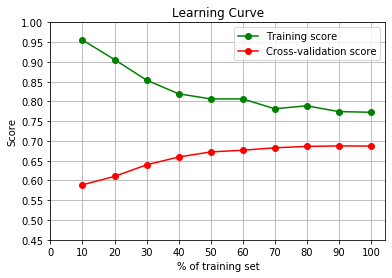

RF: 0.615840 (0.041842)
roc auc train score = 1.0
roc auc validation score = 0.61



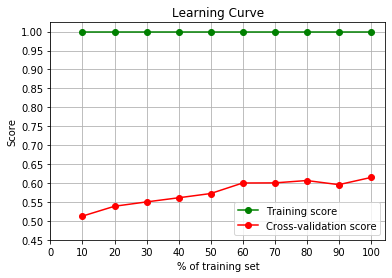

XGB: 0.760539 (0.030901)
roc auc train score = 0.88
roc auc validation score = 0.76



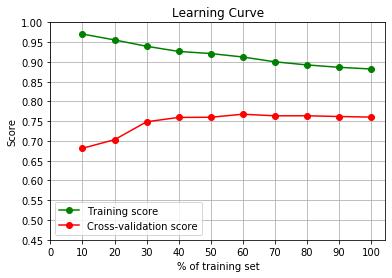

LGBM: 0.719792 (0.037150)
roc auc train score = 0.99
roc auc validation score = 0.72



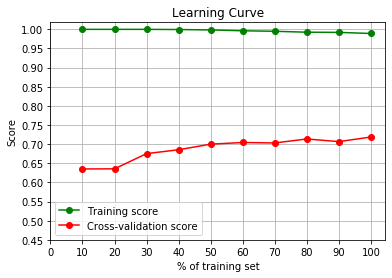

GB: 0.751571 (0.030996)


In [ ]:
%%time
#unscaled 
models = create_base_models()
names, results = evaluate(mailout_train, target, models, curve=True)
baseline_score = create_score_df(names, results)
baseline_score

In [ ]:
%%time
# standard scaler
models = get_scaled_preprocess('standard')
names, results = evaluate(mailout_train, target, models)
standard_scaler_score = create_score_df(names, results)

df_score = pd.concat([baseline_score, standard_scaler_score], axis=1)
df_score

In [ ]:
%%time
# minmax scaler
models = get_scaled_preprocess('minmax')
names, results = evaluate(mailout_train, target, models)
minmax_scaler_score = create_score_df(names, results)

df_score = pd.concat([df_score, minmax_scaler_score], axis=1)
df_score

#Since both standard scaler and min max scaler perform equally well I will stick with minmaxscaler

In [ ]:
scaler = MinMaxScaler()
scaler.fit(mailout_train.astype('float'))

mailout_train_scaled = scaler.transform(mailout_train)
mailout_test_scaled = scaler.transform(mailout_test)

# map back to dfs
mailout_train_scaled = pd.DataFrame(data=mailout_train_scaled, columns=mailout_train.columns)
mailot_test_scaled = pd.DataFrame(data=mailout_test_scaled, columns=mailout_test.columns)

### Hyperparameter tunning xgboost

In [ ]:
ITERATIONS = 300
bayes_cv_tuner_xg = BayesSearchCV(
    estimator = xgb.XGBClassifier(
        n_jobs = -1,
        objective = 'binary:logistic',
        eval_metric = 'auc',
        silent=1,
    ),
    search_spaces = {
        'learning_rate': (0.001, 1.0, 'log-uniform'),
        'max_depth': (1, 10),
        'min_child_weight': (1, 10),
        'gamma': (0.0, 1.0, 'uniform'),
        'subsample': (0.5, 1.0, 'uniform'),
        'colsample_bytree': (0.5, 1.0, 'uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'n_estimators': (50, 500),
        'scale_pos_weight': (1,90)
        
        # uncomment to test more hyperparameters
        #'max_delta_step': (0, 10),
        #'colsample_bylevel': (0.01, 1.0, 'uniform'),
        #'reg_lambda': (1e-9, 100, 'log-uniform'),
        #'scale_pos_weight': (1, 90)
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state= SEED
    ),
    n_jobs = -1,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = np.random.RandomState(50)
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format },
    all_models = pd.DataFrame(bayes_cv_tuner_xg.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner_xg.best_params_)
    
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner_xg.best_score_, 4),
        bayes_cv_tuner_xg.best_params_
    ))    
    
    # Save all model results
    clf_name = bayes_cv_tuner_xg.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [ ]:
%%time
result_xg = bayes_cv_tuner_xg.fit(mailout_train_scaled, target, callback=status_print)

In [ ]:
bayes_xgb = bayes_cv_tuner_xg.best_estimator_
bayes_xgb

### Hyperparameter tunning lgbm

In [ ]:
ITERATIONS = 300
bayes_cv_tuner_lgbm = BayesSearchCV(
    estimator = lgb.LGBMClassifier(
        application='binary',
        metric='auc',
        n_jobs=-1,
        verbose=0
    ),
    search_spaces = {
        'learning_rate': (0.01, 0.3, 'uniform'),
        'num_leaves': (2, 225),      
        'max_depth': (2, 10),
        'colsample_bytree':(0.5, 1.0, 'uniform'),
        "min_data_in_leaf":(20, 100),
        'min_child_samples': (0, 50),
        'max_bin': (100, 1000),
        'reg_lambda': (1e-9, 1.0, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'scale_pos_weight': (1,90, 'uniform'),
        'n_estimators': (20, 400),
},    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=SEED
    ),
    n_jobs = -1,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = SEED
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner_lgbm.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner_lgbm.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner_lgbm.best_score_, 4),
        bayes_cv_tuner_lgbm.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner_lgbm.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [ ]:
%%time
result_lgbm = bayes_cv_tuner_lgbm.fit(mailout_train_scaled, target, callback=status_print)

In [ ]:
bayes_lgbm = bayes_cv_tuner_lgbm.best_estimator_
bayes_lgbm

In [ ]:
print(grid.best_estimator_)